# ティックデータから VWAP の算出

In [19]:
import datetime
import os

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import dates as mdates

## Matplotlib の設定（省略可）

In [20]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 12

## ティックデータの読込

In [21]:
file = "ticks_20251006.xlsx"
body = os.path.splitext(os.path.basename(file))[0]
path_excel = os.path.join("..", "collection", file)
code = "7011"
df = pd.read_excel(path_excel, sheet_name=code)
df.index = pd.to_datetime([datetime.datetime.fromtimestamp(ts) for ts in df["Time"]])
df

,Time,Price,Volume
2025-10-06 09:21:18.419352,1.759710e+09,4247,10863000
2025-10-06 09:21:19.416535,1.759710e+09,4247,10863000
2025-10-06 09:21:20.421569,1.759710e+09,4221,10959400
2025-10-06 09:21:21.416831,1.759710e+09,4221,10959400
2025-10-06 09:21:22.410696,1.759710e+09,4202,11159800
...,...,...,...
2025-10-06 15:24:55.048785,1.759732e+09,4101,76987900
2025-10-06 15:24:56.056568,1.759732e+09,4101,76987900
2025-10-06 15:24:57.052796,1.759732e+09,4100,77026600
2025-10-06 15:24:58.068626,1.759732e+09,4100,77026600


## VWAP と 株価との乖離率 の算出

In [22]:
cum_pv = 0.0
cum_vol = 0.0
volume_prev = None
vwap_list = []
vwap_deviation_list = []


# データを逐次取得することを想定して、ループで処理
for price, volume in zip(df["Price"], df["Volume"]):
    if volume_prev is None:
        vol_diff = 0.0
    else:
        # ティックデータの出来高は累積出来高であるため
        vol_diff = volume - volume_prev

    cum_pv += price * vol_diff
    cum_vol += vol_diff
    volume_prev = volume

    # VWAP の算出
    vwap = cum_pv / cum_vol if cum_vol > 0 else price
    vwap_list.append(vwap)

    # 株価と VWAP の乖離率
    vwap_deviation = (price - vwap) / vwap
    vwap_deviation_list.append(vwap_deviation)

df["VWAP"] = vwap_list
df["VWAPdev"] = vwap_deviation_list
df

,Time,Price,Volume,VWAP,VWAPdev
2025-10-06 09:21:18.419352,1.759710e+09,4247,10863000,4247.000000,0.000000
2025-10-06 09:21:19.416535,1.759710e+09,4247,10863000,4247.000000,0.000000
2025-10-06 09:21:20.421569,1.759710e+09,4221,10959400,4221.000000,0.000000
2025-10-06 09:21:21.416831,1.759710e+09,4221,10959400,4221.000000,0.000000
2025-10-06 09:21:22.410696,1.759710e+09,4202,11159800,4208.171159,-0.001466
...,...,...,...,...,...
2025-10-06 15:24:55.048785,1.759732e+09,4101,76987900,4150.476987,-0.011921
2025-10-06 15:24:56.056568,1.759732e+09,4101,76987900,4150.476987,-0.011921
2025-10-06 15:24:57.052796,1.759732e+09,4100,77026600,4150.447462,-0.012155
2025-10-06 15:24:58.068626,1.759732e+09,4100,77026600,4150.447462,-0.012155


## 株価と VWAP のプロット

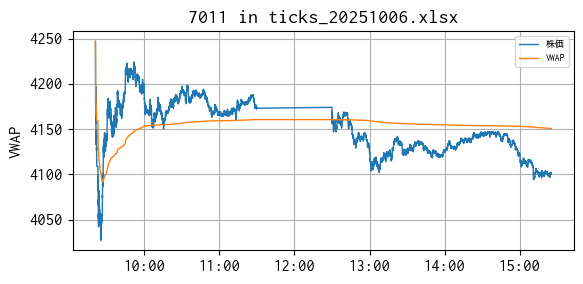

In [23]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df["Price"], linewidth=1, label="株価")
ax.plot(df["VWAP"], linewidth=1, label="VWAP")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_ylabel("VWAP")
ax.grid()
ax.legend(fontsize=7)
ax.set_title(f"{code} in {file}")

plt.tight_layout()
plt.savefig(f"{body}_{code}_vwap.png")
plt.show()

## 株価と VWAP の乖離率

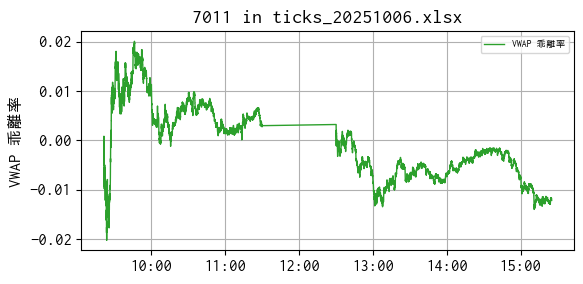

In [24]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df["VWAPdev"], linewidth=1, color="C2", label="VWAP 乖離率")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_ylabel("VWAP 乖離率")
ax.grid()
ax.legend(fontsize=7)
ax.set_title(f"{code} in {file}")

plt.tight_layout()
plt.savefig(f"{body}_{code}_vwap_dev.png")
plt.show()